<a href="https://colab.research.google.com/github/bill7845/colab_repo/blob/master/dacon_%ED%8E%80%EB%8B%A4/%ED%8E%80%EB%8B%A4_NOTE_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 기본
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.externals import joblib 
from sklearn.metrics import make_scorer

# 시계열
# from fbprophet import Prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Deep Neural Network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

# 설정
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


In [0]:
# 평가산식

def mae(prediction, correct):
    prediction = np.array(prediction)
    correct = np.array(correct)
    
    difference = correct - prediction
    abs_val = abs(difference)
    
    score = abs_val.mean()
    
    return score

mae_scorer = make_scorer(mae)
mae_scorer

make_scorer(mae)

In [0]:
# df_train = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Data_펀다/funda_train.csv')
# df_sub = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Data_펀다/submission.csv')
# df_train['transacted_date'] = pd.to_datetime(df_train['transacted_date']) # time column
# df_train = df_train.set_index('transacted_date')

# print(df_train.shape)

df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dacon_펀다/funda_train.csv')
df_sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dacon_펀다/submission.csv')
df_train['transacted_date'] = pd.to_datetime(df_train['transacted_date']) # time column
df_train = df_train.set_index('transacted_date')

print(df_train.shape)

(6556613, 8)


In [0]:
def resample_day(train_df): 
    df_day = pd.DataFrame() 
    for i in train_df.store_id.unique(): # each unique store_id 
        df_num = train_df[train_df.store_id == i] # store_id별로 적용하기 위해
        
        # 'card_id' 의 일별 counting을 통해 일 거래 횟수 확인
        count_cols = df_num['card_id'].resample(rule='d').count().rename('num_of_pay')
        
        # 'card_id' value count가 2보다 크면 단골인 것으로 판단하고 단골 방문 횟수 확인
        # 1. store_id 별 card_id에서 value_counts() 실행 => card_id를 index로 가지고 count를 값으로 반환
        # 2. count가 2이상인 단골 card_id만 추출하기 위해 reset_index 실행 => count가 2이상인 card_id의 index로 reset_index
        revisit_idx = df_num.card_id.value_counts().reset_index().query("card_id > 2")["index"].values # 단골 card_id
        # store_id 별 단골 card_id를 알아내었다.
        # 해당 card_id들을 일별로 count resampling 해주어서 일별 단골들의 결제 횟수를 추출
        revisit_ct = df_num[df_num.card_id.isin(revisit_idx)].card_id.resample(rule='d').count().rename('num_of_revisit')
        
        # 할부 개월수와 매출액은 일 단위로 합
        # store_id 별 일단위 할부개월수/매출액
        sum_cols = df_num[['installment_term', 'amount']].resample(rule='d').sum()
        
        # 일별 총거래횟수/ 일별 단골거래횟수 / 일별 매출액 /일별 할부개월수
        df_num_day = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)

        df_num_day.insert(0, 'store_id', i) # store_id 컬럼 추가
        df_num_day.insert(4, 'region', df_num[df_num.store_id == i].region.unique()[0]) # 지역 추가
        df_num_day.insert(5, 'type_of_business', df_num[df_num.store_id == i].type_of_business.unique()[0]) # 업종 추가

        df_day = pd.concat([df_day, df_num_day], axis=0) # stored_id별로 위 작업을 누적하여 concat하기 위해
        
    df_day.insert(1, 'day_of_week', df_day.index.dayofweek) # index에 몇번째 요일인가 (월,화,수 ...)
    df_day.insert(2, 'business_day', df_day.day_of_week.replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values) # 평일 1, 주말 0
    df_day.num_of_revisit.fillna(0, inplace=True) 
    
    return df_day

In [0]:
%%time
df_day = resample_day(df_train)

In [0]:
df_day.isnull().sum()

In [0]:
# df_day.to_csv('C:/Users/KIHyuk/Desktop/dacon_data/Data_펀다/funda_train_day.csv')

In [0]:
df_day = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dacon_펀다/funda_train_day.csv')
df_day['transacted_date'] = pd.to_datetime(df_day['transacted_date'])
df_day = df_day.set_index('transacted_date')

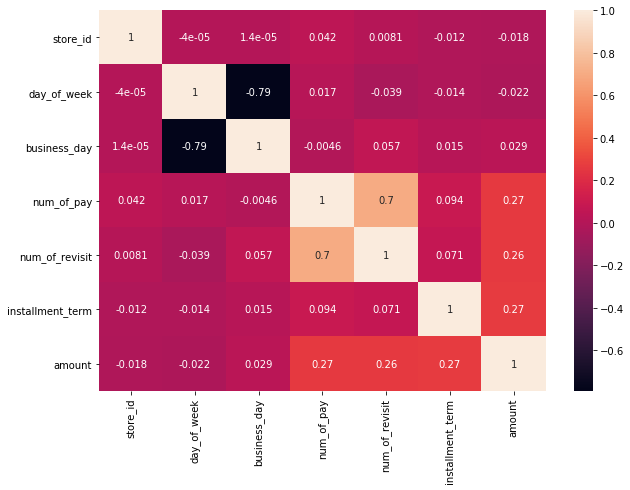

In [0]:
# 상관관계 확인

daily_corr = df_day.corr()

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.heatmap(daily_corr, annot=True)

In [0]:
df_set = df_day[df_day.store_id==1]

In [0]:
prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)), end=(df_set.index[0] - relativedelta(months=1)))
add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)), end=(df_set.index[-1] + relativedelta(months=1)))
df_set = pd.concat([pd.DataFrame(index=prev_date), df_set, pd.DataFrame(index=add_date)], axis=0)

df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1
df_set.loc[dt.strftime(df_set.index[-1], '%Y-%m'), :] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
def resample_month(frame_day):
    sum_cols = ['num_of_pay', 'num_of_revisit', 'installment_term', 'amount']

    df_monthly = pd.DataFrame()

    for i in frame_day.store_id.unique(): # each unique store_id
        df_set = frame_day[frame_day.store_id == i]
        
        # nan값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
        # store_id 별 가장 처음거래월 - 1
        # store_Id 별 가장 마지막거래월 + 1
        prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)), end=(df_set.index[0] - relativedelta(months=1)))
        add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)), end=(df_set.index[-1] + relativedelta(months=1)))
        df_set = pd.concat([pd.DataFrame(index=prev_date), df_set, pd.DataFrame(index=add_date)], axis=0)
        
        # 인위로 추가한 첫달과 마지막달의 값을 1로 채워줌
        df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1
        df_set.loc[dt.strftime(df_set.index[-1], '%Y-%m'), :] = 1
        
        # 실제로 거래가 일어난 날의 수를 월별로 count
        tot_day = df_set[df_set.amount != 0].day_of_week.resample(rule='m').count().rename('real_tot_day')
        # 실제로 거래가 일어난 영업일의 수를 월별로 sum (영업일 1,휴일0 이기때문에 결국 count됨)
        business = df_set[df_set.amount != 0].business_day.resample(rule='m').sum().rename('real_business_day')
        
        # 인위로 넣은 달의 데이터 제거 (error 제거목적 달성해서 제거해줌?..)
        business = business.drop([business.index[0], business.index[-1]], axis=0) 
        tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0)
        df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)

        df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()], axis=1)

        df.insert(0, 'store_id', i)
        df.insert(6, 'region', df_set.region.values[0])
        df.insert(7, 'type_of_business', df_set.type_of_business.values[0])

        df_monthly = pd.concat([df_monthly, df], axis=0)
   
    return df_monthly

In [0]:
%%time
df_month = resample_month(df_day)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Wall time: 1min 23s


In [0]:
df_month.isnull().sum()

store_id                 0
real_tot_day             0
real_business_day        0
num_of_pay               0
num_of_revisit           0
installment_term         0
region               20900
type_of_business     36048
amount                   0
dtype: int64

In [0]:
print("rate of 'region' :" , df_month.region.isnull().sum() / len(df_month))
print("rate of 'type_of_business' :" , df_month.type_of_business.isnull().sum() / len(df_month))

rate of 'region' : 0.34310104243618156
rate of 'type_of_business' : 0.5917754247722236


In [0]:
df_month = df_month.drop(['region', 'type_of_business'], axis=1)

In [0]:
# df_month.to_csv('C:/Users/KIHyuk/Desktop/dacon_data/Data_펀다/funda_train_month.csv')

In [0]:
df_month = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dacon_펀다/funda_train_month.csv')
df_month.rename(columns={'Unnamed: 0' : 'transacted_date'}, inplace=True)
df_month['transacted_date'] = pd.to_datetime(df_month['transacted_date'])
df_month = df_month.set_index('transacted_date')

In [0]:
df_month.isnull().sum()

store_id             0
real_tot_day         0
real_business_day    0
num_of_pay           0
num_of_revisit       0
installment_term     0
amount               0
dtype: int64

Skewness : 0.48245510908400735


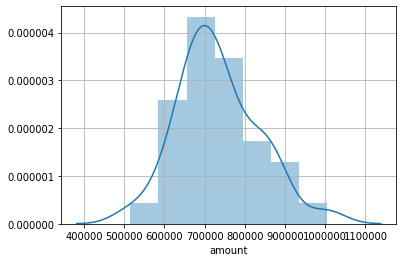

Skewness : 0.5102521050694732


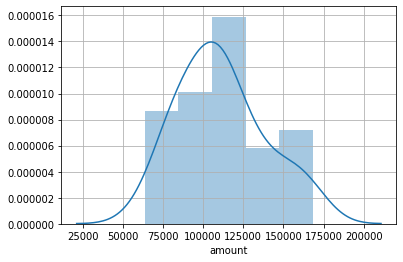

Skewness : 0.9982599271676977


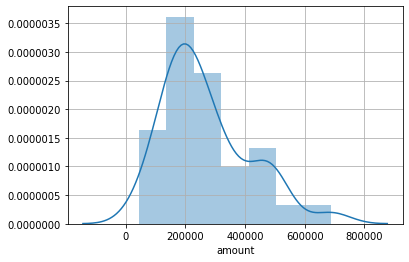

In [0]:
for i in df_month.store_id.unique()[:3]:
    print("Skewness :", df_month[df_month.store_id == i].amount.skew())
    sns.distplot(df_month[df_month.store_id == i].amount)
    plt.grid()
    plt.show()

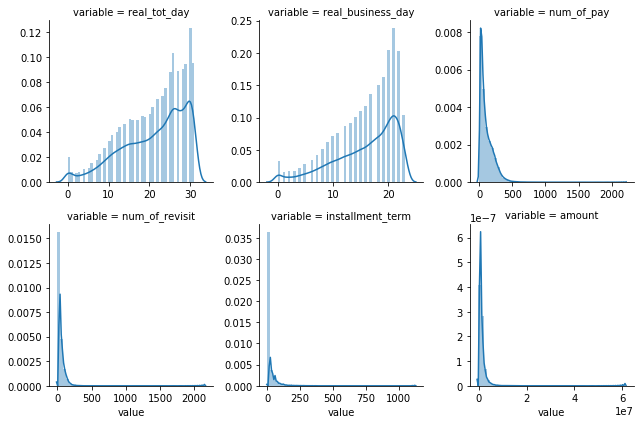

In [0]:
f = pd.melt(df_month, value_vars=df_month.columns[1:])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show() 

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


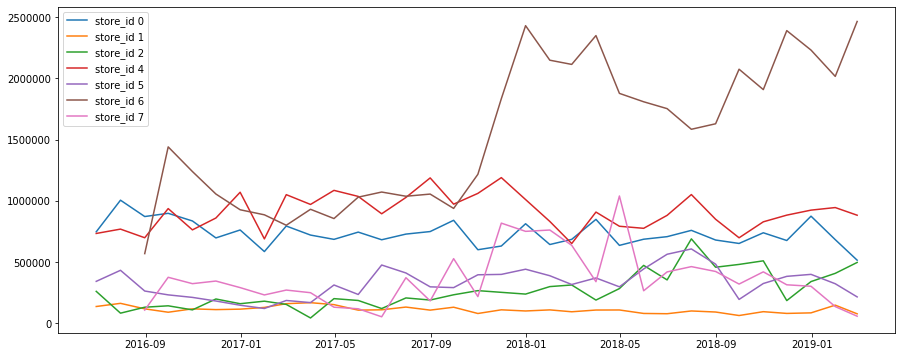

In [0]:
plt.figure(figsize=(15, 6))
for i in df_month.store_id.unique()[:7]:
    plt.plot(df_month[df_month.store_id == i].index, df_month[df_month.store_id == i].amount, label='store_id {}'.format(i))
plt.legend()

In [0]:
def plot_model_graph(data_frame, store_num, idx_col, y_cols):
    df_set = data_frame[data_frame.store_id == store_num]
    
    fig, ax1 = plt.subplots(figsize=(15, 3))
    ax1.set_xlabel("{}".format(idx_col))
    ax1.set_ylabel("{}".format(y_cols[0])).set_color(color='tab:blue')
    ax1.plot(df_set.index, df_set[y_cols[0]].values, color='tab:blue')
    
    for i in range(1, len(y_cols)):
        ax2 = ax1.twinx()
        ax2.set_ylabel("{}".format(y_cols[i])).set_color(color='C{}'.format(i))
        ax2.plot(df_set.index, df_set[y_cols[i]].values, color='C{}'.format(i))
        ax2.spines['right'].set_position(('outward', (60*(i-1))))

    fig.tight_layout()
    plt.show()

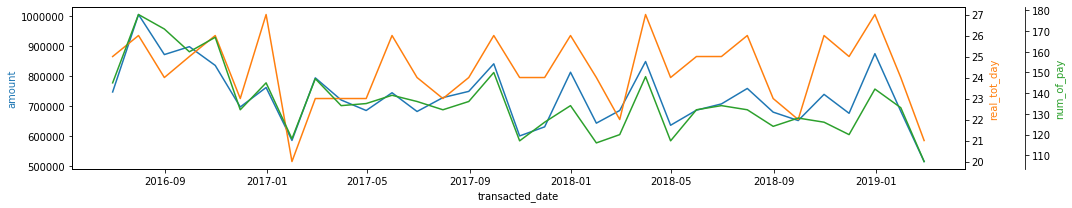

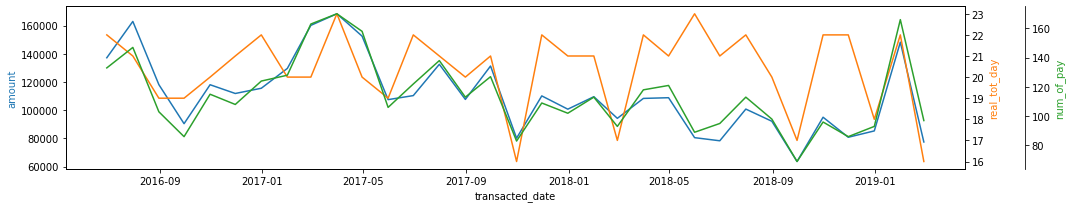

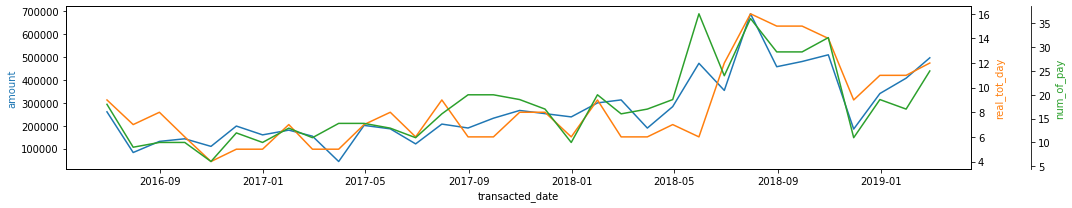

In [0]:
for i in df_month.store_id.unique()[:3]:
    plot_model_graph(df_month, i, 'transacted_date', ['amount', 'real_tot_day', 'num_of_pay'])

In [0]:
# time sereise analysis

In [0]:
## SMA

def make_sma_arr(window_num): # 이동평균 함수 # id별 지정한 window에 맞게 이동평균 col추가
    ma_arr = np.array([])
    for i in df_month.store_id.unique():
        df_set = df_month[df_month.store_id == i]
        ma_arr = np.concatenate((ma_arr, df_set.amount.rolling(window=window_num).mean().values))
        
    return ma_arr

In [0]:
sma_month = df_month.copy()

sma_month.insert(7, 'amount_2ma', make_sma_arr(2))
sma_month.insert(8, 'amount_3ma', make_sma_arr(3))
sma_month.insert(9, 'amount_6ma', make_sma_arr(6))

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


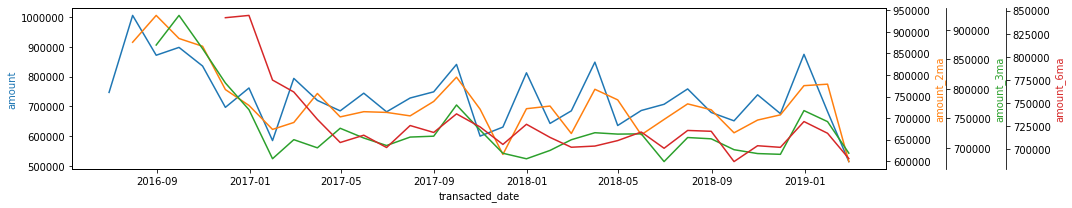

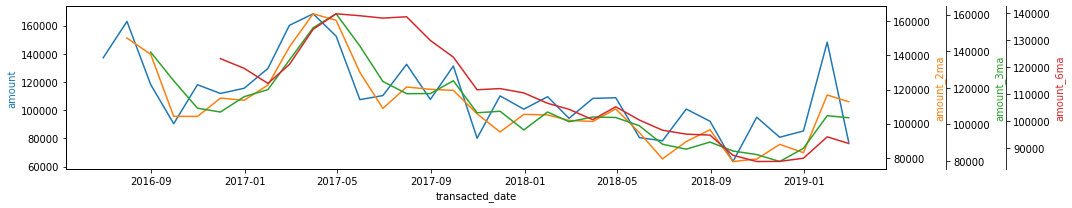

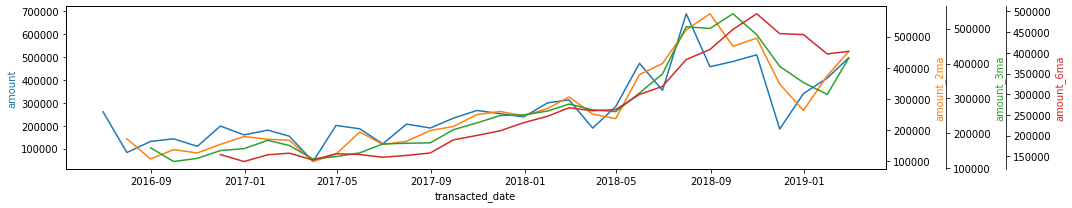

In [0]:
for i in sma_month.store_id.unique()[:3]:
    plot_model_graph(sma_month, i, 'transacted_date', ['amount', 'amount_2ma', 'amount_3ma', 'amount_6ma'])

In [0]:
print("2 winodw SMA MAE Score : ", mae(sma_month.amount_2ma.fillna(0), sma_month.amount.values))
print("3 window SMA MAE Score : ", mae(sma_month.amount_3ma.fillna(0), sma_month.amount.values))
print("6 window SMA MAE Score : ", mae(sma_month.amount_6ma.fillna(0), sma_month.amount.values))

2 winodw SMA MAE Score :  180687.25906004856
3 window SMA MAE Score :  251607.45528312284
6 window SMA MAE Score :  387465.0993765708


In [0]:
## ?????????

# rolling의 경우, window 3를 예를 들면 t 시점에 대한 값으로 t시점, t-1시점, t-2시점의 평균을 사용한다.
# 우리가 필요한 것은 t시점을 위해 t-1, t-2, t-3의 평균을 구하는 것이므로 함수를 생성하여 진행

## ** 기존 SMA 방식(위에서 한 방식)은 t시점까지의 이동평균을 구하기 위해 window가 3인경우, => t-2,t-1,t 시점의 평균을 구하는방식
## 우리는 t 시점의 데이터가 예측대상이므로, 방식을 바꾸어 t-3,t-2,t-1시점의 평균을 구할것.

def make_minus_rolling(data_frame, rolling_num):

    # 함수안의 함수
    def minus_shift_rolling(df_num, num): # 
        a = np.average(df_num.values[-num:]) # 예를들어, window가 3인경우 t-3,t-2,t-1 시점의 데이터 평균 구함
        b = np.average(np.append(df_set.values[-(num-1):], a)) # ???
        # np.append(arr,values) => 기존 arr에 추가할 values 지정
        if num > 2:
            c = np.average(np.append(np.append(df_set.values[-(num-2):], a), b))
        else:
            c = np.average((a, b))
        return np.sum((a, b, c))

    # 여기서 부터 실행

    minus_rolling_arr = np.array([])
    for i in data_frame.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount) # store_id 별 amount 
        minus_rolling_arr = np.concatenate((minus_rolling_arr, np.array([minus_shift_rolling(df_set, rolling_num)]))) # 함수안의 함수 적용하여 합침
        
    df_rolling = pd.DataFrame({'store_Id' : df_sub.store_id, 'amount' : minus_rolling_arr})
    
    return df_rolling

In [0]:
for i in range(2, 5):
    df_rolling = make_minus_rolling(df_month, i)
    # df_rolling.to_csv('/content/drive/My Drive/Time-Series/__data/sub/funda_{}_rolling_sub.csv'.format(i), index=False)

In [0]:
########### 지수 이동 평균

In [0]:
def make_ewm_arr(data_frame, span_num):
    arr_ewm = np.array([])
    for i in data_frame.store_id.unique():
        df_set = data_frame[data_frame.store_id == i]
        # 여기에서 지정하는 span값은 위 수식에서 N에 해당한다.
        arr_ewm = np.concatenate((arr_ewm, df_set.amount.ewm(span=span_num).mean().values))
    
    return arr_ewm

In [0]:
ewm_month = df_month.copy()

ewm_month.insert(7, 'amount_3ewm', make_ewm_arr(df_month, 3))
ewm_month.insert(8, 'amount_6ewm', make_ewm_arr(df_month, 6))

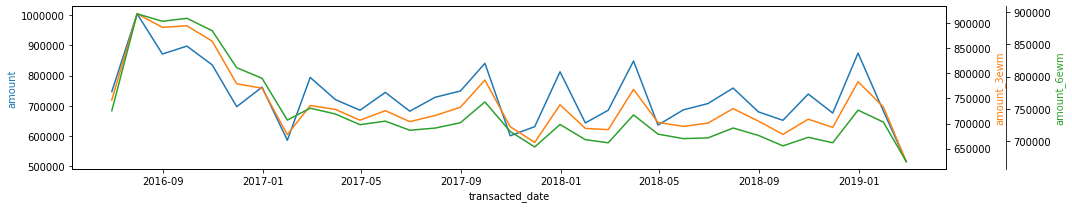

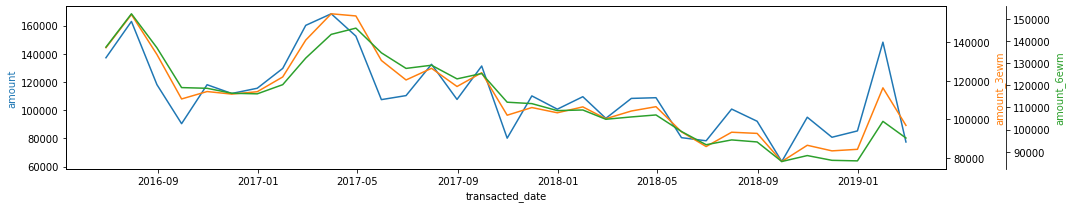

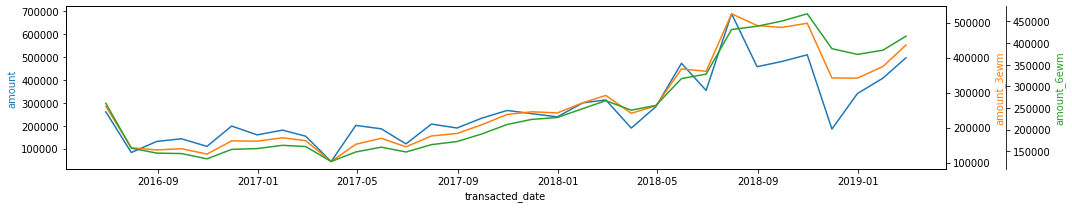

In [0]:
for i in ewm_month.store_id.unique()[:3]:
    plot_model_graph(ewm_month, i, 'transacted_date', ['amount', 'amount_3ewm', 'amount_6ewm'])

In [0]:
print("3 N EWM MAE Score : ", mae(ewm_month.amount_3ewm, sma_month.amount.values))
print("6 N EWM MAE Score : ", mae(ewm_month.amount_6ewm, sma_month.amount.values))

3 N EWM MAE Score :  134855.11946915495
6 N EWM MAE Score :  193447.63093078104


In [0]:
def make_wma_sub(data_frame, span_num):
    concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))
    wma_sub = np.array([])

    for i in df_month.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)
        wma_train = pd.concat([df_set, concat_3mon], axis=0)

        num_sub = np.array([wma_train.amount.ewm(span=span_num).mean()['2019-03':].sum()])

        wma_sub = np.concatenate((wma_sub, num_sub))
        
    df_wma_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : wma_sub})
    
    return df_wma_sub

In [0]:
concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))

df_set = pd.DataFrame(df_month[df_month.store_id == 0].amount)

wma_train = pd.concat([df_set,concat_3mon],axis=0)

num_sub = np.array([wma_train.amount.ewm(span=3).mean()['2019-03':].sum()])

wma_sub = np.array([])
wma_sub = np.concatenate((wma_sub,num_sub))
wma_sub
# df_wma_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : wma_sub})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


array([1872660.39209917])

In [0]:
for i in range(2, 7):
    wma_sub = make_wma_sub(df_month, i)
    # wma_sub.to_csv('/content/drive/My Drive/Time-Series/__data/sub/funda_{}wma_sub.csv'.format(i), index=False)

In [0]:
## ARIMA

In [0]:
p = list(range(0, 6))
d = [0, 1, 2]
q = list(range(0, 6))

pdq = list(itertools.product(p, d, q))

In [0]:
%%time
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

best_score = 10000000
best_param = 0
for param in pdq:
    try:
        arima_model = ARIMA(train.amount.values, order=param)
        result = arima_model.fit()
        if result.aic < best_score:
            best_score = result.aic
            best_param = param
    except:
        continue
        
set_arima = ARIMA(df_set.amount.values, order=best_param)
set_result = set_arima.fit()
set_pred = set_result.forecast(len(test))[0]

In [0]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("AIC Score of test :", best_score)
print("Best parameter of (p, d, q): ",best_param)

plot_train_test_pred_graph(train, test, set_pred)

In [0]:
Mean value of store_id 0 : 732559.7402597402
AIC Score of test : 557.6623843461919
Best parameter of (p, d, q):  (2, 2, 1)

In [0]:
%%time
arima_pred_arr = np.array([])
for i in df_month.store_id.unique()[:10]:
    df_set = df_month[df_month.store_id == i]

    best_score = 10000000000
    best_param = 0
    for param in pdq:
        try:
            arima_model = ARIMA(df_set.amount.values, order=param)
            result = arima_model.fit()
            # 최적 parameter는 fit에 저장되어 있는 AIC값을 기준으로 선정 한다.
            if result.aic < best_score:
                best_score = result.aic
                best_param = param
        except:
            continue

    
    arima_model = ARIMA(df_set.amount.values, order=best_param)
    arima_result = arima_model.fit()
    arima_pred = arima_result.forecast(3)[0]

    arima_pred_arr = np.concatenate((arima_pred_arr, np.array([arima_pred.sum()])))

In [0]:
arima_sum_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : arima_pred_arr})
arima_sum_sub.to_csv('./__data/sub/funda_arima_front_sum_sub.csv', index=False)